# Obama Statistics

## Significantly higher for Truth
General POS tagging (15 tags): adjectives and coordinating conjunctions

Specific POS tagging (52 tags): superlative adjectives, coordinating conjunctions

SD: adjectival modifier, (coordinating) conjunctions

## Significantly higher for Falsehoods
General POS tagging (15 tags): possessives

Specific POS tagging (52 tags): base-form, modal, auxiliary verbs

SD: auxiliary, negation modifier

# Summary

## Lemmatized Statements for Machine Learning
Lemmatized Statements (removed whitespaces, puncuation, stopwords, special characters; converted to lowercase)

## Tagged Statements
POS (part of speech): Is this word an adjective, noun, something else?

NER (named entity recognition tagging): tags the kind of noun--person, place, organization, etc.--among other things

SD (syntatic dependency): the relation between tokens

## Features Engineered from Statements
No. of characters

No. of words

Avg. length of words

Readability score

In [1]:
# import packages not on my computer through jupyter notebooks

# import sys
# !{sys.executable} -m pip install textatistic
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download en_core_web_sm # doesn't include word vectors
# !{sys.executable} -m spacy download en_core_web_md # includes word vectors

In [2]:
# for Data Manipulation
import pandas as pd
import numpy as np
import os
import csv 

# for EDA
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline   
from collections import Counter

# for NLP
from textatistic import Textatistic
import spacy
from spacy import displacy

# for Statistics
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [3]:
# Use cleaner absolute path to find file
path = os.path.abspath('politifact_obama_data.csv')
df = pd.read_csv(path, index_col=0)

# to see statement in full
pd.set_option('display.max_colwidth', 200) 

# See sample of data
df.head(3)

,statement,source,link,veracity,freq
4075,"""Refugees are subject to more rigorous screening than the average tourist in the U.S.""",Barack Obama,/global-news/statements/2016/oct/13/barack-obama/refugee-summit-obama-claims-refugees-us-are-screen/,True,101
4672,"""The steel industry is producing as much steel in the United States as it ever was. It’s just (that) it needs one-tenth of the workers that it used to.""",Barack Obama,/truth-o-meter/statements/2016/jul/05/barack-obama/barack-obama-wrong-about-size-us-steel-production-/,False,101
5049,"""Right now, here in Texas, wind power is already cheaper than dirty fossil fuels.""",Barack Obama,/texas/statements/2016/apr/12/barack-obama/barack-obama-says-wind-power-cheaper-texas-power-d/,True,101


# Dataframe column label explanations
date = date statement was made

source = source of statement

freq = frequency which source occurs in dataframe

statement = the statement which was evaluated for veracity at https://www.politifact.com

veracity = the truthfulness of a statement

In [4]:
df.veracity.value_counts()

True              62
False             34
Pants on Fire!     5
Name: veracity, dtype: int64

# data is balanced (about 60% truth)

# Preprocessing Steps: Creating a condensed (lemmatized) text
Start: Original Text

1) Lowercasing: Examples -> examples

2) Reduction to root form: examples -> example

End: Lemmatized Text

# Other Text Preprocessing Techniques
removing whitespaces, punctuation, stopwords, special characters (numbers, etc.), html/xml tags

expanding contractions (may not be needed if stopwords removed since contracted words are typically stopwords)

replacing accented characters

correcting spelling errors

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
# lemmatization function
def lemmatize(text):
    # create nlp object
    nobj = nlp(text)
    
    # stopword list from spacy
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    # simple lemmas
    lemmas = [token.lemma_ for token in nobj]
    
    # lowercase; remove non-alphabetic characters & overly used words, i.e., stop words
    a_lemmas = [lemma.lower() for lemma in lemmas
                if lemma.isalpha() 
                and lemma not in stopwords]
    
    # strings
    strings = " ".join(a_lemmas)
    
    return strings

In [7]:
df["lemmas"] = df.statement.apply(lemmatize)

# Tagging Text
POS (parts of speech; POS Tagging): Is this word an adjective, noun, something else?

NER (named entity recognition tagging; tags the kind of noun--person, place, organization, etc.--among other things)

SD (syntatic dependency): the relation between tokens

# Part of Speech (POS) Tagging

## .pos_ (general pos tagging -- 15 tags)
#### .pos_ tags are based on the Google Universal POS Tags (spaCy extends the list)

In [8]:
def dot_pos_tagger(text):
    # nlp object
    nobj = nlp(text)
    # POS tags
    tagged_text = [(token.text, token.pos_) for token in nobj]
    # tagged text
    return tagged_text

df["general_pos_tags"] = df.statement.apply(dot_pos_tagger)

## .tag_ (specific pos tagging -- 52 tags)
#### .tag_ uses OntoNotes 5 from the Penn Treebank tag set

In [9]:
def dot_tag_tagger(text):
    # nlp object
    nobj = nlp(text)
    # tags
    tagged_text = [(token.text, token.tag_) for token in nobj]
    # tagged text
    return tagged_text

df["specific_pos_tags"] = df.statement.apply(dot_tag_tagger)

# NER (named-entity recognition) tagging

In [10]:
# ner function
def ner_tagger(text):
    # nlp object
    nobj = nlp(text)
    # ner tags
    ne = [(ent.text, ent.label_) for ent in nobj.ents]
    return ne

In [11]:
df["ner_tags"] = df.statement.apply(ner_tagger)

# SD (Syntatic Dependency) tagging

In [12]:
# sd function
def sd_tagger(text):
    # nlp object
    nobj = nlp(text)
    # tags
    tagged_text = [(token.text, token.dep_) for token in nobj]
    # tagged text
    return tagged_text

df["sd_tags"] = df.statement.apply(sd_tagger)

# Feature Engineering from the original text and its lemma version
No. of characters

No. of words

Avg. length of words

In [13]:
# no. of characters
df["statement_char_count"] = df.statement.apply(len)

In [14]:
# no. of words function
def word_counter(text):
    
    # split text by blank spaces
    words = text.split()
    
    # count words
    return len(words)

In [15]:
# no. of words
df["statement_word_count"] = df.statement.apply(word_counter)

In [16]:
# avg. word length function
def avg_word_length(text):
    
    # split text into words
    words = text.split()
    
    # length of each word
    word_lengths = [len(w) for w in words] 
    
    # avg length
    avg_length = sum(word_lengths)/len(word_lengths)     
    return round((avg_length),1)

In [17]:
# avg. word length
df["statement_avg_word_len"] = df.statement.apply(avg_word_length)

# statistics

In [18]:
# func for comparing truth vs lie
def tvsf(column_label):
    
    # t & f variables
    truths = df[df['veracity'] == 'True'][column_label]
    falsehoods = df[df['veracity'] == 'False'][column_label]
    
    # means
    truths_mean = round(truths.mean(), 1)
    falsehoods_mean = round(falsehoods.mean(), 1)
    
    # t-test
    t,p = stats.ttest_ind(truths,
                          falsehoods, 
                          equal_var = False)
    if p <= 0.05:
        print("!!! SIGNIFICANT !!!")
        print(column_label, "p-value:", "{:.3f}".format(p))
    else:
        print("-Not Sgnfcnt-")
        print(column_label, "p-value:", "{:.3f}".format(p))
    print("T Avg.", column_label, ":", truths_mean)
    print("F Avg.", column_label, ":", falsehoods_mean)

In [19]:
tvsf("statement_char_count")

-Not Sgnfcnt-
statement_char_count p-value: 0.504
T Avg. statement_char_count : 96.9
F Avg. statement_char_count : 102.6


In [20]:
tvsf("statement_word_count")

-Not Sgnfcnt-
statement_word_count p-value: 0.565
T Avg. statement_word_count : 16.9
F Avg. statement_word_count : 17.7


In [21]:
tvsf("statement_avg_word_len")

-Not Sgnfcnt-
statement_avg_word_len p-value: 0.827
T Avg. statement_avg_word_len : 4.9
F Avg. statement_avg_word_len : 5.0


# lemma statistics

In [22]:
# with try and except
# b/c some lemmas do not contain words
def try_avg_word_len(text):
    try:
        return round(avg_word_length(text),1)
    except ZeroDivisionError:
        return -1

df["lemma_char_count"] = df.lemmas.apply(len)
df["lemma_word_count"] = df.lemmas.apply(word_counter)
df["lemma_avg_word_len"] = df.lemmas.apply(try_avg_word_len)

In [23]:
df.head(2)

,statement,source,link,veracity,freq,lemmas,general_pos_tags,specific_pos_tags,ner_tags,sd_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len
4075,"""Refugees are subject to more rigorous screening than the average tourist in the U.S.""",Barack Obama,/global-news/statements/2016/oct/13/barack-obama/refugee-summit-obama-claims-refugees-us-are-screen/,True,101,refugee subject rigorous screening average tourist,"[("", PUNCT), (Refugees, NOUN), (are, AUX), (subject, ADJ), (to, ADP), (more, ADV), (rigorous, ADJ), (screening, NOUN), (than, SCONJ), (the, DET), (average, ADJ), (tourist, NOUN), (in, ADP), (the, ...","[("", ``), (Refugees, NNS), (are, VBP), (subject, JJ), (to, IN), (more, RBR), (rigorous, JJ), (screening, NN), (than, IN), (the, DT), (average, JJ), (tourist, NN), (in, IN), (the, DT), (U.S., NNP),...","[(U.S., GPE)]","[("", punct), (Refugees, nsubj), (are, ROOT), (subject, acomp), (to, prep), (more, advmod), (rigorous, amod), (screening, pobj), (than, prep), (the, det), (average, amod), (tourist, pobj), (in, pre...",86,14,5.2,50,6,7.5
4672,"""The steel industry is producing as much steel in the United States as it ever was. It’s just (that) it needs one-tenth of the workers that it used to.""",Barack Obama,/truth-o-meter/statements/2016/jul/05/barack-obama/barack-obama-wrong-about-size-us-steel-production-/,False,101,steel industry produce steel united states need tenth worker use,"[("", PUNCT), (The, DET), (steel, NOUN), (industry, NOUN), (is, AUX), (producing, VERB), (as, ADV), (much, ADJ), (steel, NOUN), (in, ADP), (the, DET), (United, PROPN), (States, PROPN), (as, SCONJ),...","[("", ``), (The, DT), (steel, NN), (industry, NN), (is, VBZ), (producing, VBG), (as, RB), (much, JJ), (steel, NN), (in, IN), (the, DT), (United, NNP), (States, NNP), (as, IN), (it, PRP), (ever, RB)...","[(the United States, GPE), (one-tenth, CARDINAL)]","[("", ROOT), (The, det), (steel, compound), (industry, nsubj), (is, aux), (producing, pcomp), (as, advmod), (much, amod), (steel, dobj), (in, prep), (the, det), (United, compound), (States, pobj), ...",152,29,4.3,64,10,5.5


In [24]:
tvsf("lemma_char_count")
print("")
tvsf("lemma_word_count")
print("")
tvsf("lemma_avg_word_len")

-Not Sgnfcnt-
lemma_char_count p-value: 0.496
T Avg. lemma_char_count : 49.1
F Avg. lemma_char_count : 52.6

-Not Sgnfcnt-
lemma_word_count p-value: 0.806
T Avg. lemma_word_count : 7.5
F Avg. lemma_word_count : 7.6

-Not Sgnfcnt-
lemma_avg_word_len p-value: 0.545
T Avg. lemma_avg_word_len : 5.8
F Avg. lemma_avg_word_len : 6.0


# More Features that can be engineered
No. of sentences

No. of paragraphs

Words starting with an uppercase

All-capital words

Numeric quantities

Readability Score

# Readability Tests

In [25]:
# readability func
def readability(text):    
    # scores
    readability_scores = Textatistic(text).scores
    """ 
    Gunningfog Score depends on sentence length and syllable amount
    17 = College Graduate
    ...
    6 = 6th grade
    """
    gunningfog_score = readability_scores["gunningfog_score"]
    return gunningfog_score

# with try and except
# b/c some sentences do not end with a period
def readability_try(text):
    try:
        return round(readability(text),1)
    except ZeroDivisionError:
        return -1

In [26]:
# readability scores
df["read_score_gun"] = df.statement.apply(readability_try)

In [27]:
tvsf("read_score_gun")

-Not Sgnfcnt-
read_score_gun p-value: 0.455
T Avg. read_score_gun : 7.9
F Avg. read_score_gun : 8.6


next, we should also examine if certain kinds of words appear more often in falsehoods than in truths like adjectives or nouns

# POS dictionaries and lists for statistics

### .pos_ tag's dictionary and list

In [73]:
# first we need a dictionary and list of all the possible tags
# csv made from https://spacy.io/api/annotation#pos-tagging
# here's a df of all .pos_ tags for ease of readabilty
path = os.path.abspath('pos.csv')
dot_pos_df = pd.read_csv(path)

In [29]:
# .pos_ tags in dictionary form
with open('pos.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('pos_dict.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict_pos = {rows[0]:rows[1] for rows in reader}

In [30]:
# preview dictionary
list(mydict_pos.items())[0:3]

[('POS', 'description'),
 ('ADJ', 'adjective'),
 ('ADP', 'conjunction or particle or adverb')]

In [31]:
# delete first entry in dict, i.e., column labels
del mydict_pos["POS"]

In [32]:
# we'll use this to automate later tasks
dot_pos_list = list(mydict_pos.keys())
print(dot_pos_list[0:3])

['ADJ', 'ADP', 'ADV']


### .tag_ tag's dictionary and list

In [33]:
# df of all .tag_ tags for ease of readabilty
# csv made from https://spacy.io/api/annotation#pos-tagging
path = os.path.abspath('tags.csv')
dot_tag_df = pd.read_csv(path)
dot_tag_df[["tag","description"]][0:2]

,tag,description
0,GW,additional word in multi-word expression
1,JJ,adjective


In [34]:
# .tag_ in dictionary form
with open('tags.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('tags_dict.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict_tag = {rows[0]:rows[1] for rows in reader}

In [35]:
list(mydict_tag.items())[8:11]

[('RBS', 'adverb (superlative)'), ('AFX', 'affix'), ('CD', 'cardinal number')]

In [36]:
# delete first entry in dict, i.e., column labels
del mydict_tag["tag"]

In [37]:
# we'll use this to automate later tasks
dot_tag_list = list(mydict_tag.keys())
print(dot_tag_list[8:12])

['AFX', 'CD', 'CC', 'IN']


# Automating POS tag counts

In [38]:
def dot_pos_counter(text, p):
    # nlp object
    nobj = nlp(text)
    # list of POS tags
    pos = [token.pos_ for token in nobj]
    # count POS
    return pos.count(p)

In [39]:
# loop through the list of .pos_ tags and create new columns with counts for each tag
# this takes several minutes
for p in dot_pos_list:
    # df[p] = df.statement.apply(lambda x : proper_nouns(x, p)) #this works; check if below works in 2nd run
    df[("pos_"+mydict_pos[p])] = df.statement.apply(lambda x : dot_pos_counter(x, p))

In [40]:
def dot_tag_counter(text, t):
    # nlp object
    nobj = nlp(text)
    # list of tags
    tg = [token.tag_ for token in nobj]
    # count
    return tg.count(t)

In [41]:
# loop through the list of .tag_ tags and create new columns with counts for each tag
# this takes several minutes
for t in dot_tag_list:
    # df[p] = df.statement.apply(lambda x : proper_nouns(x, p)) #this works; check if below works in 2nd run
    df[("tag_"+mydict_tag[t])] = df.statement.apply(lambda x : dot_tag_counter(x, t))

In [42]:
df.head(1)

,statement,source,link,veracity,freq,lemmas,general_pos_tags,specific_pos_tags,ner_tags,sd_tags,...,tag_verb (base form),tag_verb (gerund or present participle),tag_verb (modal or auxiliary),tag_verb (non-3rd person singular present),tag_verb (past participle),tag_verb (past tense),tag_wh-adverb,tag_wh-determiner,tag_wh-pronoun (personal),tag_wh-pronoun (possessive)
4075,"""Refugees are subject to more rigorous screening than the average tourist in the U.S.""",Barack Obama,/global-news/statements/2016/oct/13/barack-obama/refugee-summit-obama-claims-refugees-us-are-screen/,True,101,refugee subject rigorous screening average tourist,"[("", PUNCT), (Refugees, NOUN), (are, AUX), (subject, ADJ), (to, ADP), (more, ADV), (rigorous, ADJ), (screening, NOUN), (than, SCONJ), (the, DET), (average, ADJ), (tourist, NOUN), (in, ADP), (the, ...","[("", ``), (Refugees, NNS), (are, VBP), (subject, JJ), (to, IN), (more, RBR), (rigorous, JJ), (screening, NN), (than, IN), (the, DT), (average, JJ), (tourist, NN), (in, IN), (the, DT), (U.S., NNP),...","[(U.S., GPE)]","[("", punct), (Refugees, nsubj), (are, ROOT), (subject, acomp), (to, prep), (more, advmod), (rigorous, amod), (screening, pobj), (than, prep), (the, det), (average, amod), (tourist, pobj), (in, pre...",...,0,0,0,1,0,0,0,0,0,0


# POS Statistics

### .pos_

In [43]:
""" 
since the tvsf function output would be difficult to read, let's convert to a dataframe output
"""

# func for comparing truth vs lie
def df_tvsf(tag_type, column_dict, index_list):
    #ex: df_tvsf("pos_", mydict_pos, dot_pos_list)
    
    d = []
    for x in index_list:
        
        # t & f variables
        truths = df[df['veracity'] == 'True'][tag_type+column_dict[x]]
        falsehoods = df[df['veracity'] == 'False'][tag_type+column_dict[x]]

        # means
        truths_mean = round(truths.mean(), 2)
        falsehoods_mean = round(falsehoods.mean(), 2)

        # t-test
        t,p = stats.ttest_ind(truths,
                              falsehoods, 
                              equal_var = False)
        # dataframe
        d.append({'t_means' : truths_mean, 
                  'f_means' : falsehoods_mean, 
                  'p_value' : round(p,3)})
        
    return pd.DataFrame(d, index = column_dict.values())[['t_means', 'f_means', 'p_value']]

In [44]:
# return df with probability values that approach or are significant
dot_pos_df = df_tvsf("pos_", mydict_pos, dot_pos_list)
dot_pos_df[dot_pos_df.p_value < 0.05]

,t_means,f_means,p_value
adjective,1.40,0.94,0.041
coordinating conjuction,0.37,0.15,0.026
possessive,0.21,0.62,0.004


# significantly more likely in truths: 
### adjectives and coordinating conjunctions

# significantly more likely in falsehoods: 
### possessives

### .tag_

In [46]:
# return df with probability values that approach or are significant
dot_tag_df = df_tvsf("tag_", mydict_tag, dot_tag_list)
dot_tag_df[dot_tag_df.p_value < 0.05]

,t_means,f_means,p_value
adjective (superlative),0.13,0.00,0.010
conjunction (coordinating),0.37,0.15,0.026
verb (base form),0.37,0.85,0.003
verb (modal or auxiliary),0.08,0.38,0.005


# significantly more likely in truths: 
### superlative adjectives, coordinating conjunctions

# significantly more likely in falsehoods: 
### base-form, modal, auxiliary verbs

next, we'll see if named entity recognition (identifying people, places, things, etc.) can help detect deception

# NER dictionary and list for statistics

#### let's create the NER dictionary instead of importing it this time
#### from this information found on https://spacy.io/api/annotation#named-entities
TYPE	DESCRIPTION
PERSON	People, including fictional.
NORP	Nationalities or religious or political groups.
FAC	Buildings, airports, highways, bridges, etc.
ORG	Companies, agencies, institutions, etc.
GPE	Countries, cities, states.
LOC	Non-GPE locations, mountain ranges, bodies of water.
PRODUCT	Objects, vehicles, foods, etc. (Not services.)
EVENT	Named hurricanes, battles, wars, sports events, etc.
WORK_OF_ART	Titles of books, songs, etc.
LAW	Named documents made into laws.
LANGUAGE	Any named language.
DATE	Absolute or relative dates or periods.
TIME	Times smaller than a day.
PERCENT	Percentage, including ”%“.
MONEY	Monetary values, including unit.
QUANTITY	Measurements, as of weight or distance.
ORDINAL	“first”, “second”, etc.
CARDINAL	Numerals that do not fall under another type.

In [49]:
mydict_ner = {
    "PERSON" : "people",
    "NORP" : "groups",
    "FAC" : "facilities",
    "ORG" : "organizations",
    "GPE" : "regions",
    "LOC" : "landmarks",
    "PRODUCT" : "products",
    "EVENT" : "events",
    "WORK_OF_ART" : "art",
    "LAW" : "laws",
    "LANGUAGE" : "languages",
    "DATE" : "dates",
    "TIME" : "times",
    "PERCENT" : "percentages",
    "MONEY" : "money",
    "QUANTITY" : "quantity",
    "ORDINAL" : "ordinality",
    "CARDINAL" : "numerals" 
}

In [50]:
# preview dict
list(mydict_ner.items())[0:2]

[('PERSON', 'people'), ('NORP', 'groups')]

In [51]:
ner_list = list(mydict_ner.keys())

In [52]:
def ner_counter(text, n):
    # nlp object
    nobj = nlp(text)
    # list of POS tags
    ne = [ent.label_ for ent in nobj.ents]
    # no. of proper nouns
    return ne.count(n)

In [53]:
# to loop through the list of ner tags and create new columns with counts for each tag
# this takes several minutes
for n in ner_list:
    # df[n] = df.statement.apply(lambda x : proper_nouns(x, n)) #this works
    df[("ner_"+mydict_ner[n])] = df.statement.apply(lambda x : ner_counter(x, n))

In [54]:
df.head(1)

,statement,source,link,veracity,freq,lemmas,general_pos_tags,specific_pos_tags,ner_tags,sd_tags,...,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals
4075,"""Refugees are subject to more rigorous screening than the average tourist in the U.S.""",Barack Obama,/global-news/statements/2016/oct/13/barack-obama/refugee-summit-obama-claims-refugees-us-are-screen/,True,101,refugee subject rigorous screening average tourist,"[("", PUNCT), (Refugees, NOUN), (are, AUX), (subject, ADJ), (to, ADP), (more, ADV), (rigorous, ADJ), (screening, NOUN), (than, SCONJ), (the, DET), (average, ADJ), (tourist, NOUN), (in, ADP), (the, ...","[("", ``), (Refugees, NNS), (are, VBP), (subject, JJ), (to, IN), (more, RBR), (rigorous, JJ), (screening, NN), (than, IN), (the, DT), (average, JJ), (tourist, NN), (in, IN), (the, DT), (U.S., NNP),...","[(U.S., GPE)]","[("", punct), (Refugees, nsubj), (are, ROOT), (subject, acomp), (to, prep), (more, advmod), (rigorous, amod), (screening, pobj), (than, prep), (the, det), (average, amod), (tourist, pobj), (in, pre...",...,0,0,0,0,0,0,0,0,0,0


In [75]:
# return df with probability values that approach or are significant
ner_df = df_tvsf("ner_", mydict_ner, ner_list)
ner_df[ner_df.p_value < 0.05]

,t_means,f_means,p_value


# SD (Syntatic Dependency )

In [56]:
# first we need a dictionary and list of all the possible tags
# csv made from https://spacy.io/api/annotation#pos-tagging
# here's a df of all sd tags for ease of readabilty
path = os.path.abspath('sd.csv')
sd_df = pd.read_csv(path)
sd_df[["LABEL","DESCRIPTION"]][0:2]

,LABEL,DESCRIPTION
0,acl,clausal modifier of noun (adjectival clause)
1,acomp,adjectival complement


In [57]:
# .dep tags in dictionary form
with open('sd.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('sd_dict.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict_sd = {rows[0]:rows[1] for rows in reader}

In [58]:
# preview dictionary
list(mydict_sd.items())[0:3]

[('LABEL', 'DESCRIPTION'),
 ('acl', 'clausal modifier of noun (adjectival clause)'),
 ('acomp', 'adjectival complement')]

In [59]:
# delete first entry in dict, i.e., column labels
del mydict_sd["LABEL"]

In [60]:
# we'll use this to automate later tasks
sd_list = list(mydict_sd.keys())
print(sd_list[0:3])

['acl', 'acomp', 'advcl']


# Automating sd tag counts

In [61]:
def sd_counter(text, d):
    # nlp object
    nobj = nlp(text)
    # list of tags
    dep = [token.dep_ for token in nobj]
    # count
    return dep.count(d)

In [62]:
# loop through the list of tags and create new columns with counts for each tag
# this takes several minutes
for d in sd_list:
    df[("sd_"+mydict_sd[d])] = df.statement.apply(lambda x : sd_counter(x, d))

# SD Statistics

In [63]:
# return df with probability values that approach or are significant
sd_df = df_tvsf("sd_", mydict_sd, sd_list)
sd_df[sd_df.p_value < 0.05]

,t_means,f_means,p_value
adjectival modifier,1.18,0.76,0.029
auxiliary,0.76,1.29,0.002
coordinating conjunction,0.37,0.15,0.026
conjunct,0.34,0.12,0.025
negation modifier,0.06,0.29,0.033


In [64]:
sd_df[sd_df.p_value < 0.05].index

Index(['adjectival modifier', 'auxiliary', 'coordinating conjunction',
       'conjunct', 'negation modifier'],
      dtype='object')

## significantly more likely in truths: 
adjectival modifier, (coordinating) conjunctions

## significantly more likely in falsehoods: 
auxiliary, negation modifier

# Word Clouds to visualize top words in dataset

# WordCloud().generate_from_frequencies(text) did not work in any case

There are 10198 words in the combination of all statements.


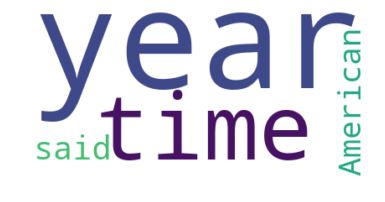

In [65]:
# Combine documents
text = " ".join( _ for _ in df.statement)
print ("There are", len(text) ,"words in the combination of all statements.")

# Generate image
wordcloud = WordCloud(min_font_size=24, 
                      max_font_size=1000, 
                      max_words=100, 
                      background_color="white").generate(text)

# Display image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [66]:
# wordcloud function for readability
def word_cloud(column):
    
    # Combine documents
    text = " ".join( _ for _ in column)
    
    # Sanity check
    print ("There are", len(text) ,"words")

    # Generate image
    plt.figure(figsize=(12, 10))
    wordcloud = WordCloud(min_font_size=5, 
                          max_font_size=60, 
                          max_words=20, 
                          background_color="white").generate(text)

    # Display the generated image
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Truth Word Clouds

There are 6068 words


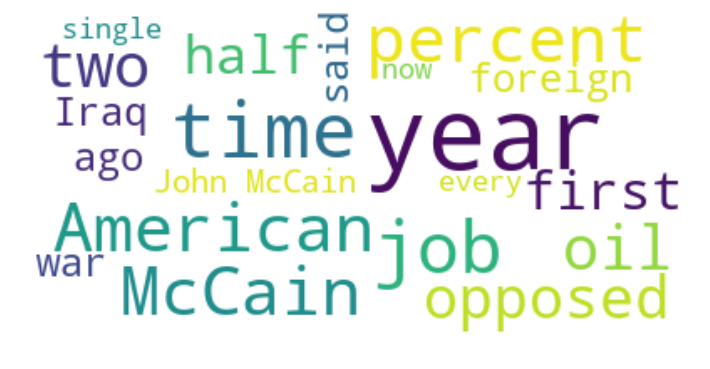

In [67]:
word_cloud(df[df.veracity == "True"].statement)

There are 3105 words


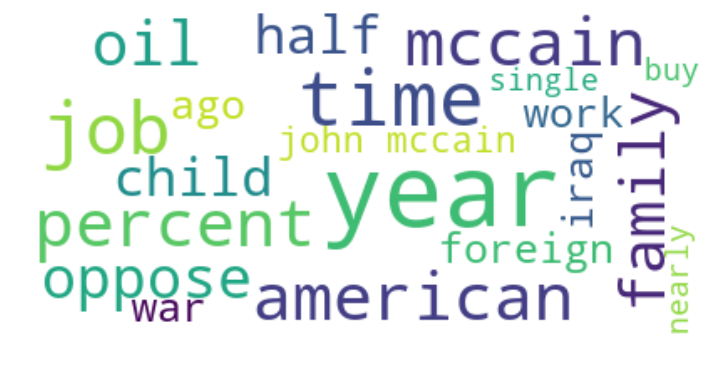

In [68]:
word_cloud(df[df.veracity == "True"].lemmas)

## Falsehood Word Clouds

There are 3522 words


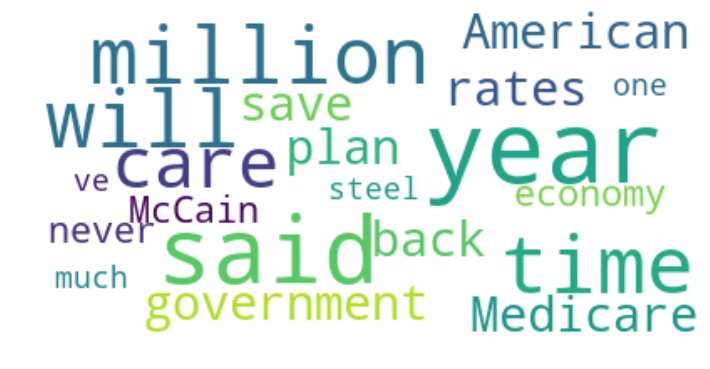

In [69]:
word_cloud(df[df.veracity == "False"].statement)

There are 1820 words


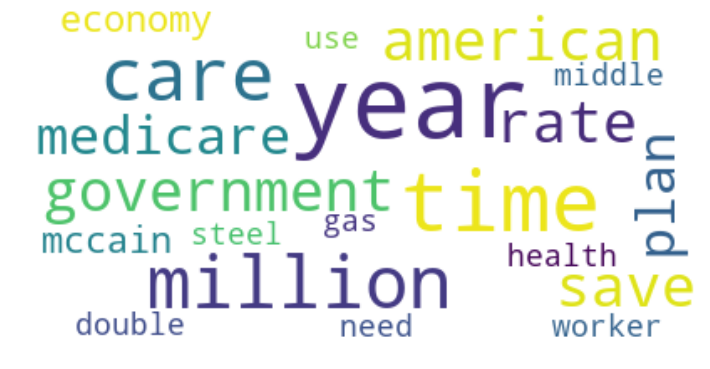

In [70]:
word_cloud(df[df.veracity == "False"].lemmas)

## Pants-on-Fire! Word Clouds

There are 606 words


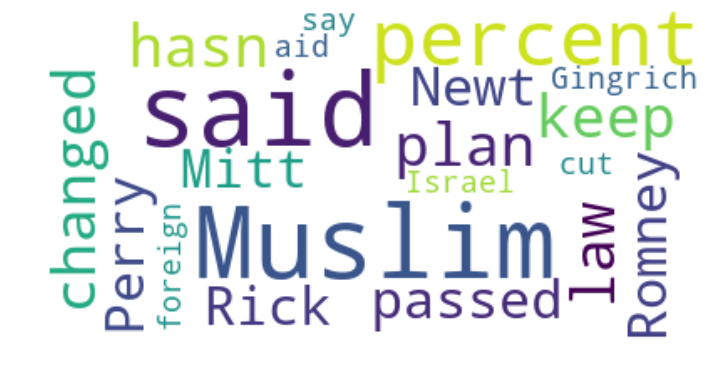

In [71]:
word_cloud(df[df.veracity == "Pants on Fire!"].statement)

There are 247 words


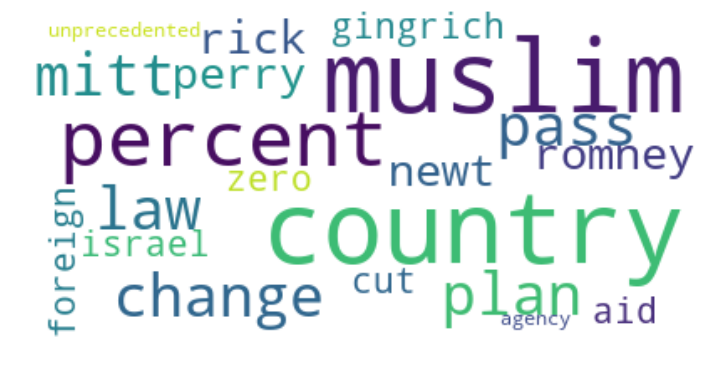

In [72]:
word_cloud(df[df.veracity == "Pants on Fire!"].lemmas)